# Let us Start by Importing Libraries required

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longit # Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print("done")

done


### Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.


In [6]:
def geo_location(address):
   # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer") 
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [31]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'MZ2QVF3VPSM5WLV1GOB44VQPSQDZVUQ4BRBITS02NT2W0Z0W' # your Foursquare ID
    CLIENT_SECRET ='USP4F2JXEXB2LMU1MMGGXUIJOYJTVM3QL30YVYXJPK5ATAD1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data= results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [62]:
CLIENT_IDI = 'Z4A4QJX4ILQY5K0PCCEBGQSC2K4LZJGFH3N24WFTZ4V5GMFR' # your Foursquare ID
CLIENT_SECRETI ='E5XKEDSOCMSRFLDTWDSHRRXIFIKC3WETYCLFKBT0GFBUYGGV'# your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [59]:

def get_venue_details(venue_id):
        
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_IDI, 
            CLIENT_SECRETI, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude

In [38]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [39]:
# get new york data
new_york_data=get_new_york_data()

In [41]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
new_york_data.shape

(306, 4)

In [16]:
#So there are total of 306 different Neighborhoods in New York

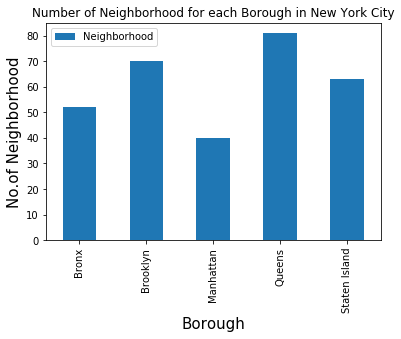

In [17]:
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### Now we will collect Indian resturants for each Neighborhood

In [43]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [23]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [24]:
indian_rest_ny.shape

(153, 4)

### We have here total 153 Restaurants 

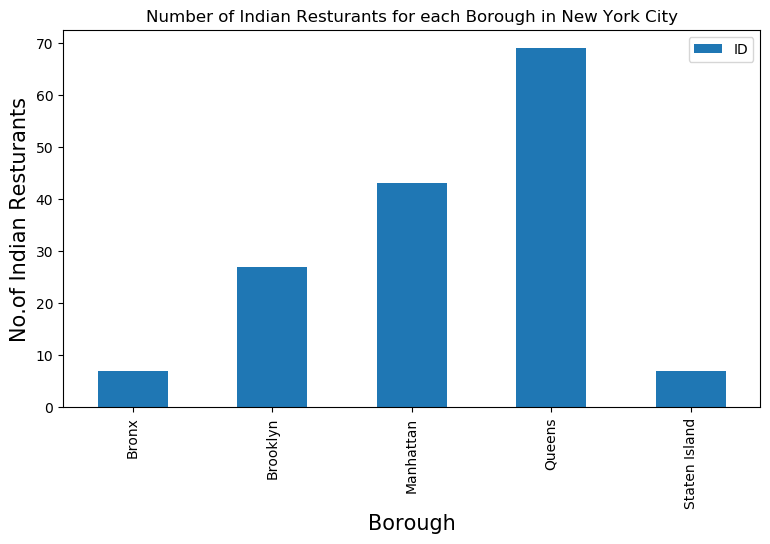

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Queens has largest number of restaurants 

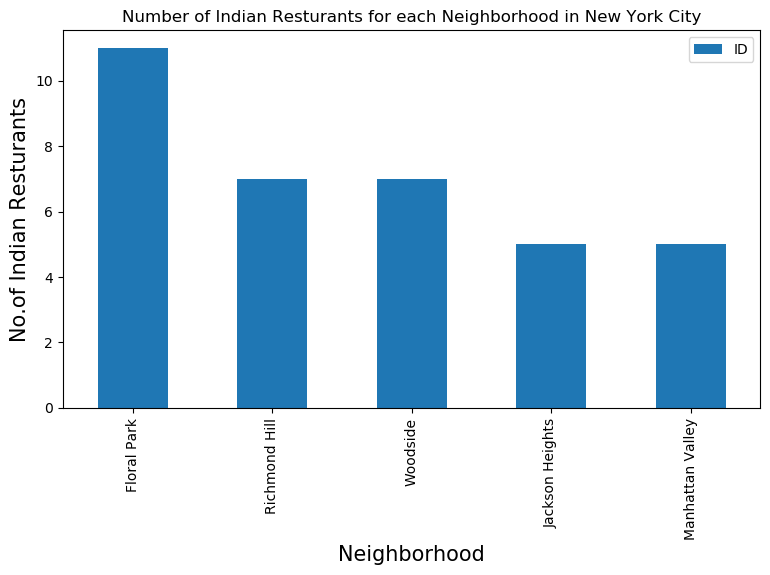

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [29]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
100,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
101,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
102,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
103,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
104,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
105,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
106,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
107,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,5d06c43cc03635002cc463f2,Honest


In [63]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
  

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.0    11
( 1 / 153 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 2 / 153 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 3 / 153 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 4 / 153 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.9     3
( 5 / 153 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 6 / 153 ) processed
                         ID       Name  Likes  Rat

In [64]:

indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Bronx,Parkchester,0,0,0,0.0,0
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3


In [65]:

indian_rest_stats_ny.shape

(153, 7)

In [66]:

indian_rest_ny.shape

(153, 4)

##### So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [67]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [68]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [69]:
indian_rest_stats_ny_csv.shape

(153, 7)

In [70]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Bronx,Parkchester,0,0,0,0.0,0
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3


In [72]:
indian_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 7 columns):
Borough         153 non-null object
Neighborhood    153 non-null object
ID              153 non-null object
Name            153 non-null object
Likes           153 non-null int64
Rating          153 non-null float64
Tips            153 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.5+ KB


In [73]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')


In [74]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [75]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 7 columns):
Borough         153 non-null object
Neighborhood    153 non-null object
ID              153 non-null object
Name            153 non-null object
Likes           153 non-null float64
Rating          153 non-null float64
Tips            153 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.5+ KB


In [76]:

# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 41, dtype: object

In [78]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 146
Name: 44, dtype: object

In [79]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 41, dtype: object

###### Now lets visualize neighborhood with maximum average rating of resturants

In [80]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [81]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Astoria,9.00
68,Tribeca,9.00
64,Sunnyside,9.00
6,Blissville,9.00
12,Civic Center,9.00
30,Greenwich Village,8.90
74,West Village,8.85
48,Noho,8.80
43,Midtown South,8.70
42,Midtown,8.70


#### Above are the top neighborhoods with top average rating of Indian resturants

In [82]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [83]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.251163
1,Brooklyn,7.318519
3,Queens,6.439130
0,Bronx,5.657143
4,Staten Island,4.514286


#### Similarly these are the average rating of Indian Resturants for each Borough

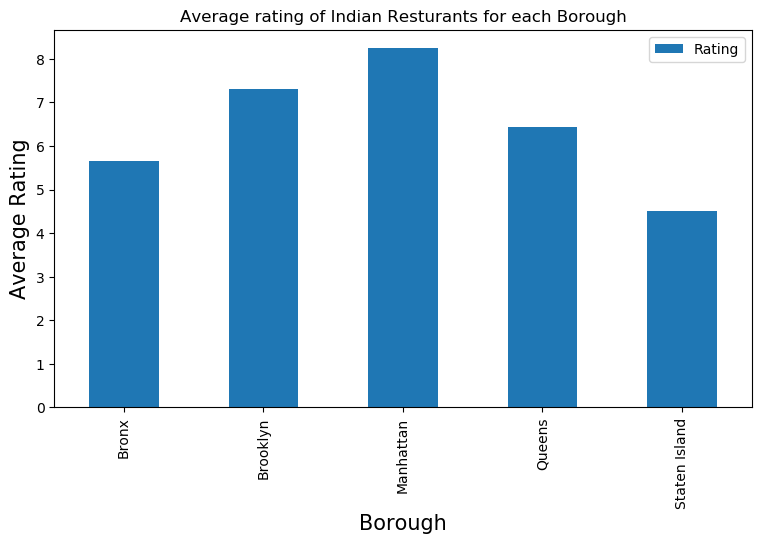

In [84]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [87]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]          

In [89]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,9.0
6,Blissville,9.0
12,Civic Center,9.0
64,Sunnyside,9.0
68,Tribeca,9.0


In [90]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [91]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [92]:

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.0
1,Queens,Blissville,40.737251,-73.932442,9.0
2,Manhattan,Civic Center,40.715229,-74.005415,9.0
3,Queens,Sunnyside,40.740176,-73.926916,9.0
4,Staten Island,Sunnyside,40.612760,-74.097126,9.0
5,Manhattan,Tribeca,40.721522,-74.010683,9.0


In [93]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [94]:

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [95]:
#let's add new field to dataframe for labelling 

In [97]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [98]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [119]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

json_url=r'USA New York City neighborhood 20190128.geojson'
ny_map.choropleth(
    geo_data=json_url,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
ny_map




# Conclusion 
#### We can conclude that Manhattan have the potential market for indian restaurants
#### Astoria(Queens), Blissville(Queens) and Civic Center(Manhattan) have some of the major Indian 


# Limitations
#### Based on Foursquare limited Data
#### Based purely on ratings